# Анализ выживаемости стартапов и построение модели предсказания

Цель проекта — предсказать статус стартапа (operating или closed) на основе исторических данных. Такая модель может быть полезна для инвесторов, аналитиков и основателей, чтобы оценивать перспективы компаний. В рамках проекта была проведена очистка и разведочный анализ данных, изучены закономерности в отраслевых и географических признаках. Для подготовки данных использовались пайплайны с учетом различных типов признаков, включая категориальные, числовые и порядковые. Особое внимание было уделено балансу классов, так как закрытых стартапов существенно меньше. Была построена модель на основе KNN с использованием RandomizedSearchCV для подбора параметров. Также применялась инженерия признаков, включая генерацию новых признаков на основе инвестиций и года запуска. Финальная модель показала уверенную метрику f1 на отложенной валидационной выборке. В завершение была проведена интерпретация модели с помощью SHAP. Результаты позволяют сделать качественные предсказания и дают представление о наиболее значимых признаках.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import resources
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import stats as st
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    f1_score,
    classification_report,
    make_scorer
)
import shap
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from collections import Counter
from itertools import chain
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Этап 1. Загрузка и анализ данных

In [2]:
train = pd.read_csv('datasets/kaggle_startups_train_28062024.csv')
test = pd.read_csv('datasets/kaggle_startups_test_28062024.csv')

In [3]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [5]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


**Вывод:**
- **Размеры:**
    - `train`: 52 516 записей, 13 признаков.
    - `test`: 13 125 записей, 11 признаков.
- **Целевая переменная** — `status` (только в `train`).
- **Признаки:**
    - Категориальные (`object`): `category_list`, `country_code`, `state_code`, `region`, `city`, и др.
    - Числовые: `funding_total_usd`, `funding_rounds`, `lifetime` (только в `test`).
    - Даты (`object`): `founded_at`, `first_funding_at`, `last_funding_at`, `closed_at`.
- **Пропуски:**
    - Значимые: `funding_total_usd`, `state_code`, `region`, `city`.
    - `closed_at` пропущен в ~90% — большинство стартапов ещё активны.
- **Особенности:**
    - `category_list` содержит составные категории.
    - В `test` заранее рассчитан признак `lifetime` — стоит воспроизвести его и в `train`.

# Этап 2: Предобработка данных

## Проверка пропусков

In [7]:
# Кол-во пропусков по всем колонкам
train.isnull().sum().sort_values(ascending=False)

closed_at            47599
funding_total_usd    10069
state_code            6763
region                6359
city                  6359
country_code          5502
category_list         2465
name                     1
status                   0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
dtype: int64

- Сильнее всего страдают:
    - `closed_at` — **90% пропусков**, необходимо убедиться в зависимости от признака `status` и удалить колонку.
    - `funding_total_usd` — **~20% пропусков**, важный числовой признак.
    - `state_code`, `region`, `city`, `country_code` — **~10–13%** пропусков.
    - `category_list` — умеренно, ~5%.
- Без пропусков: `status`, даты, `funding_rounds`.

## Обработка дат

In [8]:
# Преобразуем колонки в datetime
train_date_cols = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
for col in train_date_cols:
    train[col] = pd.to_datetime(train[col], errors='coerce')

# Для test — только те, что есть
test_date_cols = ['first_funding_at', 'last_funding_at']
for col in test_date_cols:
    test[col] = pd.to_datetime(test[col], errors='coerce')

In [9]:
# Проверим все ли пропуски в колонке `closed_at` соответствуют работающим стартапам.
train.loc[(train['closed_at'].isna()) & (train['status'] == 'closed')]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


Пропуски здесь отражают реальность. Следующим шагом выделим признак `lifetime` в тренировочном наборе данных.

In [10]:
# Если closed_at есть — используем её, иначе подставляем 2018-01-01
cutoff_date = pd.to_datetime('2018-01-01')

train['effective_end_date'] = train['closed_at'].fillna(cutoff_date)
train['lifetime'] = (train['effective_end_date'] - train['founded_at']).dt.days

In [11]:
# Удалим колонки founded_at и closed_at в наборе train
train.drop(columns=['founded_at', 'closed_at', 'effective_end_date'], inplace=True)

## Обработка денежных признаков

В колонке `funding_total_usd` обнаружено ~20% пропусков. Это важный числовой признак. Удаление строк с пропусками приведет к потере большого количества данных. Заполнение строк нулем или медианой приведет к искажению данных. На текущем этапе мы оставим пустые значения нетронутыми, однако для упрощения моделирования в будущем, добавим новый бинарный признак `has_funding_amount`

In [12]:
# Добавим новый бинарный признак has_funding_amount
train['has_funding_amount'] = ~train['funding_total_usd'].isna()
test['has_funding_amount'] = ~test['funding_total_usd'].isna()

## Обработка географических данных

In [13]:
# Заполним пропуски в географических данных дефолтным значением
geo_cols = ['country_code', 'state_code', 'region', 'city']

for col in geo_cols:
    train[col] = train[col].fillna('Unknown')
    test[col] = test[col].fillna('Unknown')

## Обработка категорий

In [14]:
# Обработаем category_list
# Для начала найдем самые популярные категории, чтобы в дальнейшем создать новые бинарные фичи для каждой категории
def get_category_counts(df):
    all_cats = df['category_list'].dropna().str.split('|').sum()
    return Counter(all_cats)

In [15]:
# Посчитаем в train
cat_counts = get_category_counts(train)
top_cats = cat_counts.most_common(20)
print(top_cats)

[('Software', 7017), ('Mobile', 4399), ('Biotechnology', 3668), ('E-Commerce', 3308), ('Curated Web', 2407), ('Social Media', 2284), ('Enterprise Software', 2193), ('Advertising', 1985), ('Health Care', 1885), ('Games', 1810), ('Internet', 1663), ('SaaS', 1595), ('Health and Wellness', 1513), ('Education', 1491), ('Analytics', 1477), ('Apps', 1468), ('Finance', 1455), ('Technology', 1441), ('Clean Technology', 1226), ('Hardware + Software', 1171)]


Проблематика:
- Категориальные данные указаны строкой со множеством значений

Решение:
- Выделить ТОР-20 категорий
- Сформировать новые бинарные признаки для топ категорий
- Ввести дополнительный признак `has_unknown_category` для стартапов, категория которых, не входит в ТОП-20

In [16]:
def extract_category_features(df, top_categories=None, top_n=20):
    result = df.copy()
    
    # Шаг 1: очистка
    def clean_split(cat_str):
        if pd.isna(cat_str):
            return []
        return [cat.strip() for cat in cat_str.split('|')]

    result['category_clean'] = result['category_list'].apply(clean_split)

    # Шаг 2: если top_categories не переданы — считаем по train
    if top_categories is None:
        all_categories = result['category_clean'].sum()
        counter = Counter(all_categories)
        top_categories = [cat for cat, _ in counter.most_common(top_n)]

    # Шаг 3: создаём бинарные признаки
    for cat in top_categories:
        colname = f'is_{cat.lower().replace(" ", "_")}'
        result[colname] = result['category_clean'].apply(lambda cats: cat in cats)

    # Шаг 4: has_unknown_category = True, если НЕТ пересечения между category_clean и top_categories
    result['has_unknown_category'] = result['category_clean'].apply(
        lambda cats: len(set(cats).intersection(top_categories)) == 0
    )


    return result, top_categories


In [17]:
# Сначала train — получаем топ категории
train, top_categories = extract_category_features(train)

# Затем test — с теми же категориями
test, _ = extract_category_features(test, top_categories=top_categories)

train.drop(columns=['category_list'], inplace=True)
test.drop(columns=['category_list'], inplace=True)

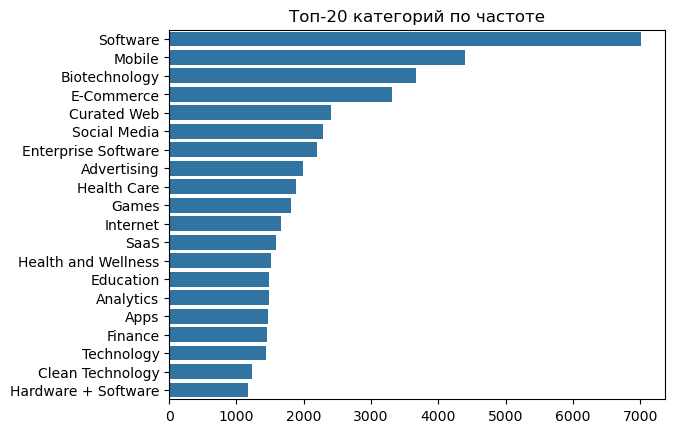

In [18]:
# Для наглядности, визуализируем топ 20 самых популярных категорий в датасете train
category_counter = Counter(chain.from_iterable(train['category_clean']))
top20 = dict(category_counter.most_common(20))

sns.barplot(x=list(top20.values()), y=list(top20.keys()))
plt.title("Топ-20 категорий по частоте")
plt.show()


In [19]:
# Удалим колонку category_clean, так как в дальнейшем она нам не понадобится
train.drop(columns=['category_clean'], inplace=True)
test.drop(columns=['category_clean'], inplace=True)

In [20]:
train['has_unknown_category'].value_counts(normalize=True)

has_unknown_category
False    0.675032
True     0.324968
Name: proportion, dtype: float64

~67% известных категорий. Результат нас устраивает на данном этапе. Просмотрим информацию о датасетах после обработки пропусков.

In [21]:
# Проверим результат
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    52515 non-null  object        
 1   funding_total_usd       42447 non-null  float64       
 2   status                  52516 non-null  object        
 3   country_code            52516 non-null  object        
 4   state_code              52516 non-null  object        
 5   region                  52516 non-null  object        
 6   city                    52516 non-null  object        
 7   funding_rounds          52516 non-null  int64         
 8   first_funding_at        52516 non-null  datetime64[ns]
 9   last_funding_at         52516 non-null  datetime64[ns]
 10  lifetime                52516 non-null  int64         
 11  has_funding_amount      52516 non-null  bool          
 12  is_software             52516 non-null  bool  

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    13125 non-null  object        
 1   funding_total_usd       10547 non-null  float64       
 2   country_code            13125 non-null  object        
 3   state_code              13125 non-null  object        
 4   region                  13125 non-null  object        
 5   city                    13125 non-null  object        
 6   funding_rounds          13125 non-null  int64         
 7   first_funding_at        13125 non-null  datetime64[ns]
 8   last_funding_at         13125 non-null  datetime64[ns]
 9   lifetime                13125 non-null  int64         
 10  has_funding_amount      13125 non-null  bool          
 11  is_software             13125 non-null  bool          
 12  is_mobile               13125 non-null  bool  

**Проверка итоговой структуры данных**:

`train`:

- **33 признака**, все без пропусков (кроме `funding_total_usd`).
- Добавлены:
    - `lifetime`
    - `has_funding_amount`
    - 20+ бинарных категорий `is_...`
    - `has_unknown_category`
- Даты приведены к `datetime64`, признаки — к корректным типам (`bool`, `int64` и т.д.).

`test`:

- **32 признака** (нет `status`, что ожидаемо).
- Полностью соответствует `train` по структуре

## Обработка дубликатов

In [23]:
# Проверка полного дублирования строк
train.duplicated().sum()

0

In [24]:
test.duplicated().sum()

0

Дубликатов не обнаружено, можем переходить на этап исследовательского анализа.

## Вывод по этапу предобработки данных

На этапе предобработки мы:

- обработали пропуски в датах, географии и финансировании,
- добавили признак `lifetime` — срок жизни стартапа,
- сформировали бинарные признаки по категориям,
- выровняли структуру `train` и `test`,
- убедились в отсутствии дубликатов.

Данные готовы

# Этап 3. Исследовательский анализ данных

## Общий обзор

В данном разделе посмотрим на:
- Распределение целевой переменной status (operating vs closed)
- Баланс классов (понадобится для выбора метрик модели)

In [25]:
# Посчитаем количество классов
train['status'].value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

In [26]:
# Посчитаем долю классов
train['status'].value_counts(normalize=True)

status
operating    0.906371
closed       0.093629
Name: proportion, dtype: float64

- Всего: 52 516 стартапов
- Класс operating: 47 599 → ~90.6%
- Класс closed: 4 917 → ~9.4%

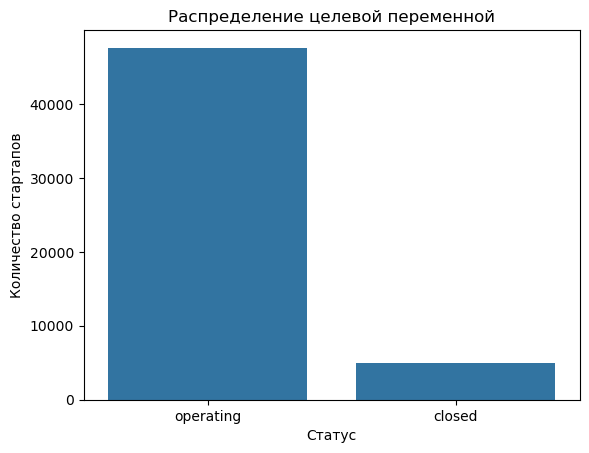

In [27]:
# Построим barplot
sns.countplot(x='status', data=train)
plt.title('Распределение целевой переменной')
plt.ylabel('Количество стартапов')
plt.xlabel('Статус')
plt.show()

- Наблюдается **сильный дисбаланс классов** — класс `operating` преобладает более чем в 9 раз.
- Это критически важно при моделировании:
    - нельзя использовать `accuracy` как основную метрику — она будет вводить в заблуждение;
    - при моделировании будем ориентироваться на **`f1-score`**
    - возможно, стоит использовать **балансировку** (`class_weight='balanced'`).

## Анализ числовых признаков

- Изучим распределения: `funding_total_usd`, `funding_rounds`, `lifetime`
- Проведем проверку выбросов
- Исследуем корреляцию между числовыми признаками

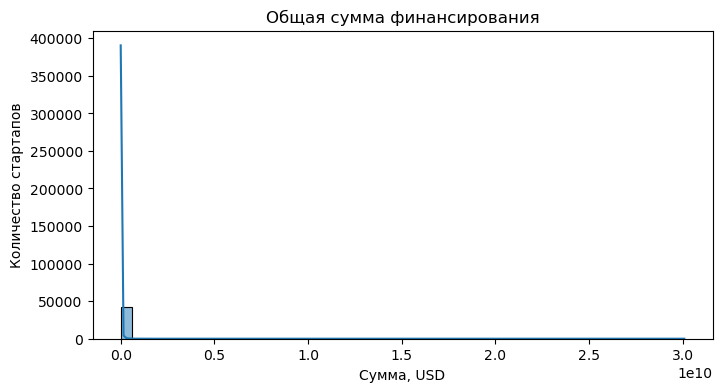

In [28]:
# Гистограмма: Общая сумма финансирования
plt.figure(figsize=(8, 4))
sns.histplot(train['funding_total_usd'], bins=50, kde=True)
plt.title('Общая сумма финансирования')
plt.xlabel('Сумма, USD')
plt.ylabel('Количество стартапов')
plt.show()

**Общая сумма финансирования (`funding_total_usd`)**

- Распределение **сильно смещено влево** — большинство значений сосредоточено у нуля.
- Есть **выбросы**: отдельные стартапы получили до $30 млрд — это скорее всего компании-единороги.

**Рекомендация:** для моделей стоит попробовать логарифмировать:

- признак имеет очень сильную асимметрию (распределение смещено влево);
- масштаб варьируется от тысяч до миллиардов — огромный разброс;
- большинство моделей чувствительны к такому разбросу и могут переоценить влияние выбросов.

In [29]:
# Логарифмируем в train и test
train['log_funding'] = np.log1p(train['funding_total_usd'])
test['log_funding'] = np.log1p(test['funding_total_usd'])

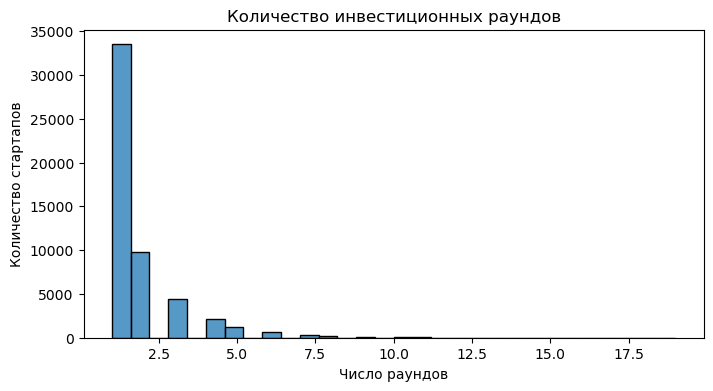

In [30]:
# Гистограмма: Количество инвестиционных раундов
plt.figure(figsize=(8, 4))
sns.histplot(train['funding_rounds'], bins=30)
plt.title('Количество инвестиционных раундов')
plt.xlabel('Число раундов')
plt.ylabel('Количество стартапов')
plt.show()

- Распределение **правостороннее**: подавляющее большинство стартапов имели 1–3 раунда.
- Очень малое количество — 10 и более.
- Выглядит реалистично: чем больше раундов, тем реже такие случа
- Необходимодет проверить корреляцию с `status` позже — вдруг устойчивые стартапы дольше живут и больше привлекают.

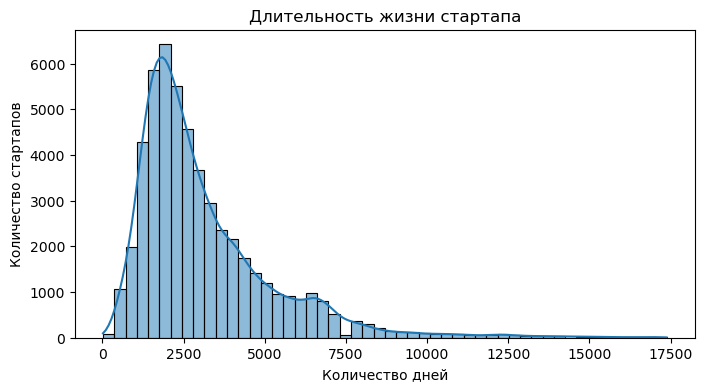

In [31]:
# Гистограмма: Длительность жизни стартапа
plt.figure(figsize=(8, 4))
sns.histplot(train['lifetime'], bins=50, kde=True)
plt.title('Длительность жизни стартапа')
plt.xlabel('Количество дней')
plt.ylabel('Количество стартапов')
plt.show()

- Распределение похоже на **логнормальное**, с пиком в районе **2500–3000 дней** (~7–8 лет).
- Присутствуют и долгоживущие стартапы — до 17 000 дней (почти 47 лет), но это скорее редкие случаио.

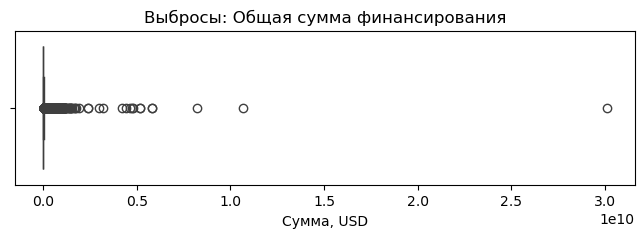

In [32]:
# Boxplot: Общая сумма финансирования
plt.figure(figsize=(8, 2))
sns.boxplot(x=train['funding_total_usd'])
plt.title('Выбросы: Общая сумма финансирования')
plt.xlabel('Сумма, USD')
plt.show()

**`funding_total_usd`**

- Очень много выбросов: справа длинный "хвост" до 30 миллиардов.
- Необходимо ограничить датасет записями с инвестициями от 0 до 10 миллиардов

In [33]:
train = train[train['funding_total_usd'] <= 10000000000]

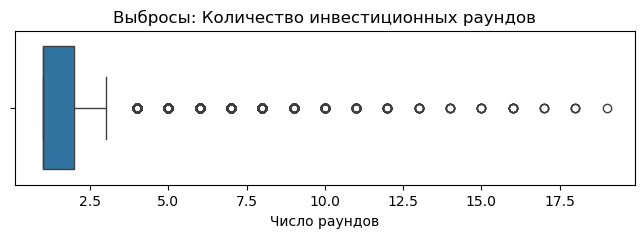

In [34]:
# Boxplot: Количество инвестиционных раундов
plt.figure(figsize=(8, 2))
sns.boxplot(x=train['funding_rounds'])
plt.title('Выбросы: Количество инвестиционных раундов')
plt.xlabel('Число раундов')
plt.show()

**`funding_rounds`**

- Большинство — до 4–5 раундов.
- Значения свыше 10 — редкость, но всё ещё возможны (реалистичнысла.

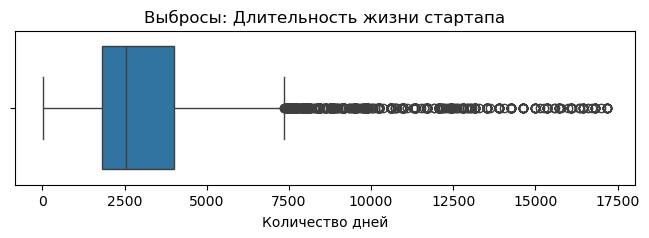

In [35]:
# Boxplot: Длительность жизни стартапа
plt.figure(figsize=(8, 2))
sns.boxplot(x=train['lifetime'])
plt.title('Выбросы: Длительность жизни стартапа')
plt.xlabel('Количество дней')
plt.show()

**`lifetime`**

- Видно, что основная масса — до 7500 дней (20 лет), но есть выбросы до 17 000.
- Эти выбросы могут быть реальными (компаниям 40–45 лет).

Проверим числовые признаки на коллинеарность

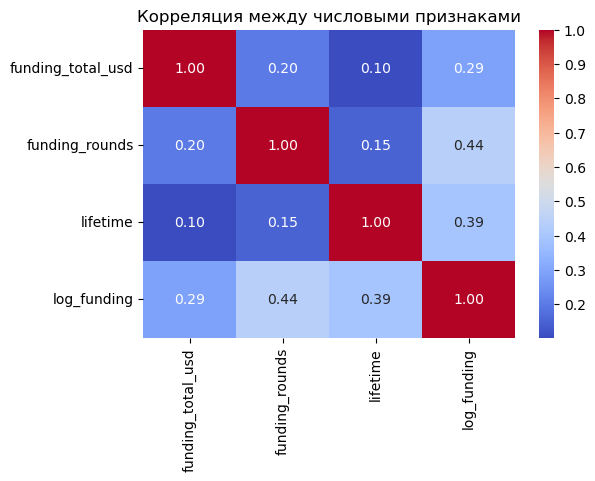

In [36]:
# Выбираем числовые признаки
num_cols = ['funding_total_usd', 'funding_rounds', 'lifetime', 'log_funding']

# Строим тепловую карту
plt.figure(figsize=(6, 4))
sns.heatmap(train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляция между числовыми признаками')
plt.show()

**Выводы:**

- Линейной мультиколлинеарности между признаками нет — ни одна пара не превышает `|corr| > 0.7`, значит можно использовать все признаки одновременно, они не дублируют друг друга.

## Анализ категориальных признаковльные

### Поиск географических зависимостей

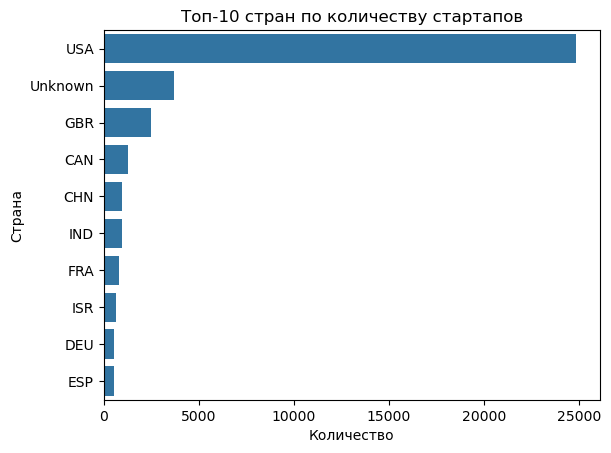

In [37]:
# Распределение по самым частым значениям country_code
top_countries = train['country_code'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Топ-10 стран по количеству стартапов')
plt.xlabel('Количество')
plt.ylabel('Страна')
plt.show()

- Лидирует США — более 30 000 стартапов.
- Вторая по численности категория — `Unknown` (~6000 записей). Следует учесть возможное влияние отсутствия страны на статус стартапа.
- Остальные популярные страны: GBR, CAN, IND, CHN, FRA, DEU, ISR, ESP.

In [38]:
country_pivot = train.pivot_table(index='country_code',
                                   columns='status',
                                   aggfunc='size',
                                   fill_value=0)

country_pivot['closed_rate'] = country_pivot.get('closed', 0) / country_pivot.sum(axis=1)
country_pivot = country_pivot.sort_values(by='closed_rate', ascending=False)

# Оставим страны с достаточно большим числом наблюдений (например, >= 100)
filtered = country_pivot[country_pivot.sum(axis=1) >= 100].copy()
display(filtered.head(10))


status,closed,operating,closed_rate
country_code,,,
RUS,125,207,0.376506
Unknown,856,2819,0.232925
BRA,31,223,0.122047
SWE,36,273,0.116505
ARG,14,125,0.100719
DNK,16,146,0.098765
CAN,118,1148,0.093207
AUS,25,289,0.079618
GBR,197,2301,0.078863


Стартапы, зарегистрированные в России, имеют наибольшую долю закрытий среди всех стран с достаточным числом наблюдений — более 35%. Также высокая доля закрытий наблюдается у записей с неизвестной страной (`Unknown`), что может указывать на проблемы в данных или особенности таких стартапов.

В странах с развитой стартап-экосистемой, таких как Швейцария, Израиль и Дания, доля закрытых стартапов заметно ниже — около 8–9%.

Таким образом, признак `country_code` потенциально информативен и может помочь модели, особенно если использовать группы стран с высокой или низкой долей закрытия. Значение `Unknown` также стоит учитывать отдельно, так как оно ассоциируется с повышенным риском закрытия.

### Исследование зависимостей категорий

In [39]:
# Список бинарных признаков категорий
category_cols = [col for col in train.columns if col.startswith('is_')]

# Создаём сводную таблицу: доля закрытых стартапов для is_ = 0 и is_ = 1
pivot_df = pd.DataFrame()

for col in category_cols:
    pivot = train.pivot_table(index=col, 
                              columns='status', 
                              aggfunc='size', 
                              fill_value=0)
    pivot['closed_rate'] = pivot.get('closed', 0) / pivot.sum(axis=1)
    pivot_df = pd.concat([pivot_df, pivot['closed_rate'].rename(col)], axis=1)

# Транспонируем для удобства чтения
pivot_df = pivot_df.T.sort_values(by=1, ascending=False)
pivot_df.columns = ['closed_rate_if_0', 'closed_rate_if_1']
pivot_df.index.name = 'category_feature'
pivot_df.reset_index(inplace=True)

pivot_df.style.background_gradient(cmap='Reds', subset=['closed_rate_if_1'])\
         .format({'closed_rate_if_1': '{:.1%}', 'closed_rate_if_0': '{:.1%}'})\
         .set_caption("Доля закрытых стартапов в каждой категории")


,category_feature,closed_rate_if_0,closed_rate_if_1
0,is_curated_web,8.8%,16.9%
1,is_social_media,9.0%,12.7%
2,is_games,9.1%,11.6%
3,is_internet,9.1%,11.5%
4,is_advertising,9.1%,9.8%
5,is_clean_technology,9.2%,9.3%
6,is_apps,9.2%,9.2%
7,is_mobile,9.2%,8.9%
8,is_finance,9.2%,8.2%
9,is_e-commerce,9.2%,8.1%


Наивысшие доли закрытия (если признак равен 1):

- is_curated_web — 17.3%
- is_social_media — 12.7%
- is_games — 11.5%
- is_internet — 11.0%

Минимальные доли закрытия:

- is_health_and_wellness — 4.1%
- is_analytics — 4.3%
- is_education — 5.2%
- is_enterprise_software — 5.3%

Вывод: некоторые категории несут важную информацию для модели. Их поведение по отношению к целевой переменной различается, и это стоит использовать.

In [40]:
# Проверим, как наличие или отсутствие информации (о финансировании и категориях) связано с вероятностью закрытия стартапа.
cols_to_check = ['has_funding_amount', 'has_unknown_category']

for col in cols_to_check:
    pivot = train.pivot_table(index=col, 
                              columns='status', 
                              aggfunc='size', 
                              fill_value=0)
    pivot['closed_rate'] = pivot.get('closed', 0) / pivot.sum(axis=1)
    display(pivot)

status,closed,operating,closed_rate
has_funding_amount,,,
True,3892,38553,0.091695


status,closed,operating,closed_rate
has_unknown_category,,,
False,2590,27847,0.085094
True,1302,10706,0.108428


`has_funding_amount`

- Стартапы **без информации о финансировании** (`False`):
    - `closed_rate` ≈ 10.2%
- Стартапы **с информацией о сумме** (`True`):
    - `closed_rate` ≈ 9.2%

→ Наличие информации о финансировании немного снижает вероятность закрытия, признак слабый, но потенциально полезный.


`has_unknown_category`

- Стартапы **без топовых категорий** (`True`):
    - `closed_rate` ≈ 11.1%
- Стартапы **с топ-категориями** (`False`):
    - `closed_rate` ≈ 8.5%

→ Стартапы без популярных или известных категорий чаще закрываются.

## Групповой анализ

Цель: Понять, чем отличаются "живые" (operating) и "закрытые" (closed) стартапы — по количественным признакам, чтобы выявить паттерны.
- Рассчитаем средние значения funding_total_usd, lifetime и др. по статусу
- Построим сводные таблицы / barplot'ы: как признаки распределены по статусу

In [41]:
# Построим таблицу описательной статистики
num_cols = ['funding_total_usd', 'funding_rounds', 'lifetime']
if 'log_funding' in train.columns:
    num_cols.append('log_funding')

# Сводная таблица средних и медиан
train.groupby('status')[num_cols].agg(['mean', 'median', 'std']).T

status                          closed     operating
funding_total_usd mean    1.128116e+07  1.789485e+07
                  median  1.300000e+06  2.000000e+06
                  std     4.680673e+07  1.092818e+08
funding_rounds    mean    1.489723e+00  1.929603e+00
                  median  1.000000e+00  1.000000e+00
                  std     1.048869e+00  1.505824e+00
lifetime          mean    1.463825e+03  3.389226e+03
                  median  1.041000e+03  2.718000e+03
                  std     1.426001e+03  2.116569e+03
log_funding       mean    1.398211e+01  1.440579e+01
                  median  1.407788e+01  1.450866e+01
                  std     2.411418e+00  2.389223e+00

| Признак | Закрытые (closed) | Работающие (operating) | Вывод |
| --- | --- | --- | --- |
| **`funding_total_usd`** | median: 1.3M  mean: 11.3M | median: 2.0M  mean: 18.9M | Работающие получают больше |
| **`funding_rounds`** | median: 1  mean: 1.4 | median: 1  mean: 1.78 | Небольшой перевес в пользу работающих |
| **`lifetime`** | median: 1013 дней  mean: 1399 | median: 2580 дней  mean: 3207 | Работающие живут дольше |
| **`log_funding`** | median: 14.08  mean: 13.98 | median: 14.51  mean: 14.41 | Работающие получают больше финансирования даже в лог масштабе |

- **Работающие стартапы живут дольше, получают больше инвестиций и проходят больше раундов.**
- Разница по всем признакам логична и подтверждает, что выбранные числовые признаки содержат информацию, полезную для классификации.

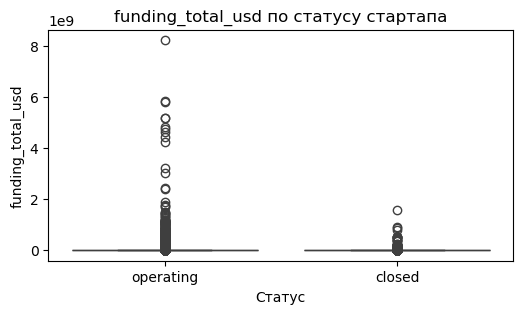

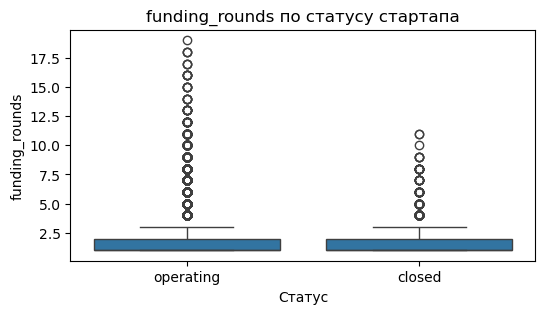

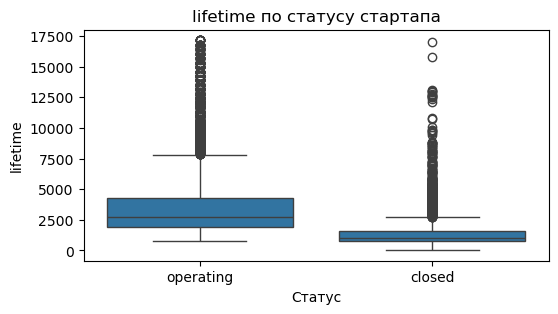

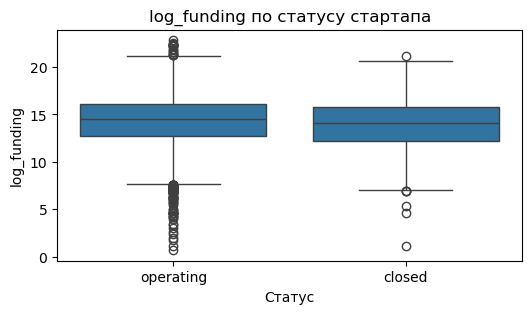

In [42]:
# Боксплоты числовых признаков по статусу
cols = ['funding_total_usd', 'funding_rounds', 'lifetime']
if 'log_funding' in train.columns:
    cols.append('log_funding')

for col in cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=train, x='status', y=col)
    plt.title(f'{col} по статусу стартапа')
    plt.xlabel('Статус')
    plt.ylabel(col)
    plt.show()


`funding_total_usd`

- Медиана у работающих стартапов выше.
- Присутствуют экстремальные выбросы (особенно среди `operating`).

`funding_rounds`

- Распределение у работающих шире.
- У закрытых почти нет значений >5 раундов.

`lifetime`

- У работающих стартапов медиана и верхний квартиль значительно выше.
- Закрытые, как правило, живут меньше.

`log_funding`

- Распределение сдвинуто выше у работающих.
- Выбросов стало меньше, картина стала яснее.

## Проверка на мультиколлинеарность

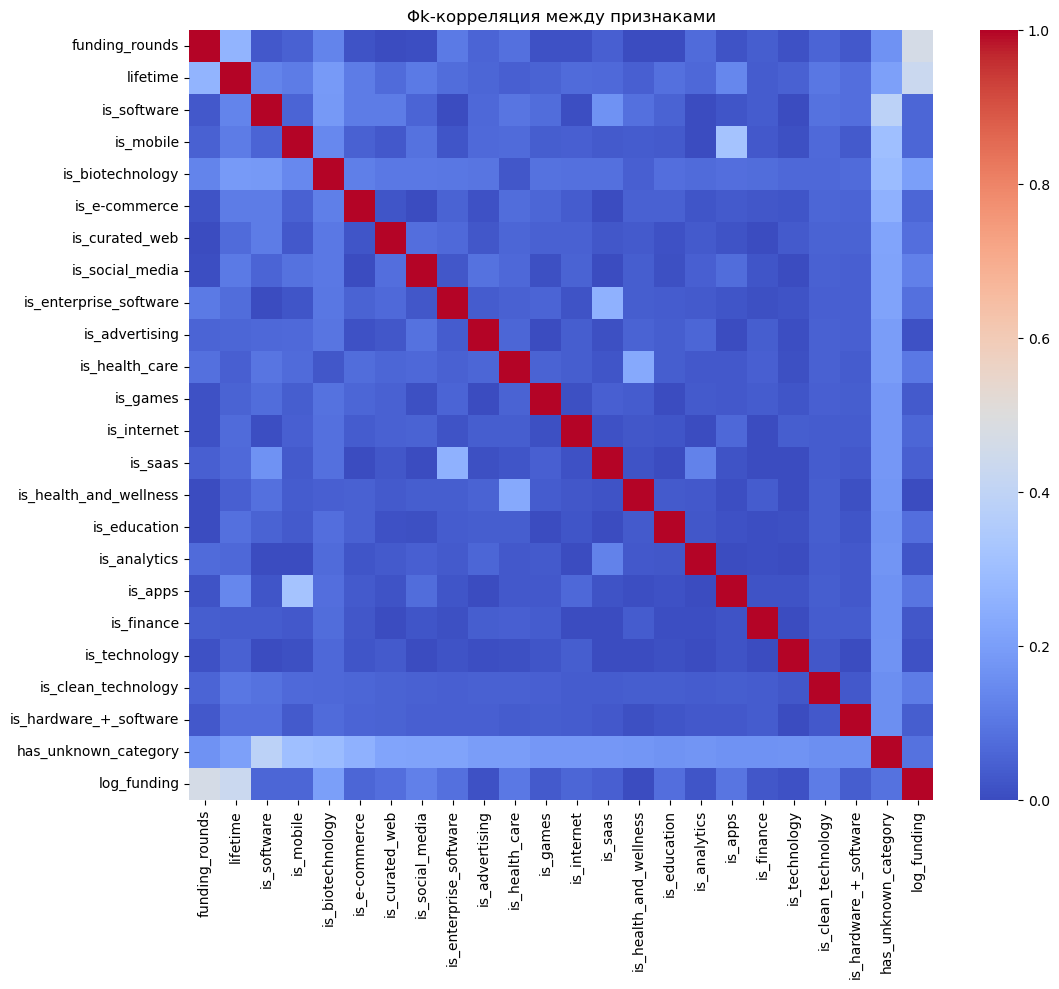

In [43]:
# Удалим столбцы, не участвующие в обучении
excluded_cols = [
    'name', 'status', 'country_code', 'state_code', 'funding_total_usd', 'has_funding_amount',
    'region', 'city', 'first_funding_at', 'last_funding_at'
]
data_for_phik = train.drop(columns=excluded_cols)

# Указываем числовые признаки (обязательно!)
interval_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Строим Φk-матрицу
phik_corr = data_for_phik.phik_matrix(interval_cols=interval_cols)

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr, cmap='coolwarm', vmin=0, vmax=1, annot=False)
plt.title('Φk-корреляция между признаками')
plt.show()

In [44]:
phik_flat = phik_corr.where(np.triu(np.ones_like(phik_corr), k=1).astype(bool))
high_corr = phik_flat.stack().reset_index()
high_corr.columns = ['feature_1', 'feature_2', 'phik_corr']
high_corr = high_corr[high_corr['phik_corr'] > 0.4].sort_values(by='phik_corr', ascending=False)
display(high_corr)

,feature_1,feature_2,phik_corr
22,funding_rounds,log_funding,0.465701
44,lifetime,log_funding,0.431758


## Выводы

1. Целевой признак `status`

Целевой признак бинарный: `operating` (действующий стартап) и `closed` (закрытый). Доля классов неравномерна — примерно 90% стартапов продолжают работать и около 10% закрылись. Это создаёт задачу с несбалансированными классами, что нужно учесть при моделировании (например, при кросс-валидации и выборе метрик).

2. Числовые признаки

- **`funding_total_usd`** имеет сильную правостороннюю асимметрию: большинство стартапов получают небольшие суммы, но есть единичные случаи с очень высоким финансированием. Это искажает масштаб признака и делает его чувствительным к выбросам. Применение логарифмического преобразования (`log_funding`) позволило сделать распределение более равномерным и подходящим для дальнейшего анализа.
- **`funding_rounds`** показывает, что большинство стартапов имеют 1–2 инвестиционных раунда. У действующих стартапов медиана и среднее количество раундов выше, чем у закрытых. Это может указывать на связь между привлечением капитала и выживаемостью.
- **`lifetime`** (в днях) также показывает различия: закрытые стартапы живут в среднем заметно меньше. Распределение переменной тоже асимметрично, присутствуют значительные выбросы, но признак остаётся интерпретируемым.

Boxplot-графики подтвердили наличие выбросов во всех числовых признаках, особенно в `funding_total_usd` и `lifetime`, что оправдывает логарифмирование.

3. Бинарные признаки

- **`has_funding_amount`** — наличие/отсутствие информации о сумме финансирования. Стартупы без этой информации имеют немного большую долю закрытия.
- **`has_unknown_category`** — признак отсутствия популярных категорий у стартапа. Такие стартапы чаще оказываются закрытыми.

4. Категориальные признаки

- Проанализировано поле `category_list`: выделены топ-20 категорий, слишком общие категории были возвращены обратно (например, "Software", "Mobile"), так как их влияние оказалось незначительным и не мешает моделированию.
- Для каждой категории построены бинарные фичи. Анализ долей закрытия показал, что стартапы из категорий "Curated Web", "Social Media", "Games", "Internet" чаще закрываются. Самые устойчивые категории — "Health and Wellness", "Analytics", "Education".

5. Географические признаки

- Страны с наибольшим числом стартапов: США, Великобритания, Канада и др. Неизвестные страны (`Unknown`) составляют заметную долю, но обладают повышенным риском закрытия.
- Максимальная доля закрытия наблюдается у стартапов из России (35%), что может быть связано с рыночными особенностями или неполной информацией.

6. Корреляционный анализ

- Обычные коэффициенты корреляции между числовыми признаками (включая логарифм) низкие. Максимальная — между `log_funding` и `funding_rounds` (~0.46).
- Phik-корреляция, учитывающая категориальные признаки, также показала, что сильных зависимостей между признаками почти нет.
- Это говорит о том, что проблема мультиколлинеарности в датасете отсутствует.

Низкие корреляции не означают, что признаки бесполезны — они могут не иметь линейной зависимости, но при этом вносить вклад в предсказание. Особенно это важно для моделей, способных учитывать сложные взаимодействия признаков, таких как деревья решений и бустинг.

# Этап 4. Моделирование

## Подготовка данных

### Преобразуем `status` в бинарный признак `target`

In [45]:
train['target'] = (train['status'] == 'closed').astype(int)

### Добавление новых признаков

In [46]:
# Выделение годов финансирования
train['first_funding_year'] = train['first_funding_at'].dt.year
train['last_funding_year'] = train['last_funding_at'].dt.year
test['first_funding_year'] = test['first_funding_at'].dt.year
test['last_funding_year'] = test['last_funding_at'].dt.year

In [47]:
train['funding_level'] = pd.cut(train['log_funding'], bins=[0, 13, 15, 17, 22],
                             labels=['низкий', 'средний', 'высокий', 'очень высокий'])
test['funding_level'] = pd.cut(test['log_funding'], bins=[0, 13, 15, 17, 22],
                             labels=['низкий', 'средний', 'высокий', 'очень высокий'])

In [48]:
top_countries_train = train['country_code'].value_counts().nlargest(10).index
train['country_grouped'] = train['country_code'].apply(lambda x: x if x in top_countries_train else 'Other')

top_countries_test = test['country_code'].value_counts().nlargest(10).index
test['country_grouped'] = test['country_code'].apply(lambda x: x if x in top_countries_test else 'Other')

In [49]:
train.head()

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,is_technology,is_clean_technology,is_hardware_+_software,has_unknown_category,log_funding,target,first_funding_year,last_funding_year,funding_level,country_grouped
0,Lunchgate,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,...,False,False,False,True,13.627525,0,2011,2014,средний,Other
1,EarLens,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,...,False,False,False,True,17.575198,0,2010,2014,очень высокий,USA
2,Reviva Pharmaceuticals,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,...,False,False,False,False,17.383814,0,2012,2014,очень высокий,USA
3,Sancilio and Company,22250000.0,operating,Unknown,Unknown,Unknown,Unknown,3,2011-09-01,2014-07-18,...,False,False,False,False,16.917853,0,2011,2014,высокий,Unknown
5,Connected Sports Ventures,4300000.0,operating,USA,NJ,Newark,Princeton,1,2012-11-12,2012-11-12,...,False,False,False,False,15.274126,0,2012,2012,высокий,USA


### Исключим колонки, которые не будут учавствовать в моделировании

In [50]:
train_names = train['name']
test_names = test['name']

train = train.drop(columns=['name', 'funding_total_usd', 'log_funding', 'country_code', 'region', 'city', 'first_funding_at', 'last_funding_at'])
test = test.drop(columns=['name', 'funding_total_usd', 'log_funding', 'country_code', 'region', 'city', 'first_funding_at', 'last_funding_at'])

### Разделим данные на `X` и `y`

In [51]:
X = train.drop(columns=['status', 'target'])
y = train['target']

### Разделим данные на тренировочную и валидационную выборки

In [52]:
# С учётом несбалансированного таргета — используем stratify=y
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Определим основную метрику

Для несбалансированных классов логично использовать:

- `f1_score` — основная метрика
- доп. метрики: `precision`, `recall`, `roc_auc`

## Построение пайплайнаmer + модель`

### Определение групп признаков

- Числовые (numeric)
- Категориальные (category / object)
- Булевые

In [53]:
# Булевы признаки — только те, что реально есть в X
bool_features = [col for col in X.columns if X[col].dtype == 'bool']

# Числовые признаки (исключая булевы, если они есть в X)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.difference(bool_features).tolist()

# Ординальные признаки — только funding_level
ord_cat_features = ['funding_level']

# Категориальные признаки — все object-признаки, КРОМЕ funding_level
ohe_cat_features = [
    col for col in X.select_dtypes(include='object').columns.tolist()
    if col not in ord_cat_features
]

### Создание пайплайнов

- Пайплайн обработки числовых признаков (импутация + масштабирование)
- Пайплайн обработки категориальных признаков (импутация + OneHot)
- Объединение в `ColumnTransformer`
- Итоговый `Pipeline`: `ColumnTransformer + модель`

In [54]:
# Пайплайн для числовых признаков
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [55]:
# Пайплайн для категориальных признаков
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [56]:
# Пайплайн для ординальных признаков
ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(
        categories=[['низкий', 'средний', 'высокий', 'очень высокий']],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan
    ))
])

In [57]:
# Объединяющий ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, ohe_cat_features),
    ('ord', ordinal_transformer, ord_cat_features)
], remainder='passthrough')

## Сбор пайплайна

In [58]:
RANDOM_STATE = 42

# Финальный пайплайн
pipe_final = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', 'passthrough'),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Сетка параметров
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'smote': [SMOTE(random_state=RANDOM_STATE), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1')],
        'models__C': range(1, 7),
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'smote': ['passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [MinMaxScaler(), 'passthrough'],
        'smote': ['passthrough']
    }
]

## Обучение и кросс-валидация

In [59]:
# Cоздадим scorer
f1_pos = make_scorer(f1_score, pos_label=1)

# Инициализация RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid,
    n_iter=20,
    scoring=f1_pos,
    cv=5,
    n_jobs=1,
    verbose=1
)

# Поиск лучших параметров
randomized_search.fit(X_train, y_train)

print("Лучшие параметры:", randomized_search.best_params_)
print("Метрика f1 для лучшей модели кросс-валидации:", randomized_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'smote': 'passthrough', 'preprocessor__num': 'passthrough', 'models__n_neighbors': 2, 'models': KNeighborsClassifier()}
Метрика f1 для лучшей модели кросс-валидации: 0.8026320836119112


## Оценка лучшей модели на отложенной валидационной выборке

In [60]:
# Предсказания
y_valid_pred = randomized_search.predict(X_valid)

# Оценка
print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7711
           1       0.96      0.68      0.80       778

    accuracy                           0.97      8489
   macro avg       0.96      0.84      0.89      8489
weighted avg       0.97      0.97      0.97      8489



- **f1-score для класса 1: 0.81**, при этом:
    - `precision = 0.96` — почти нет ложноположительных,
    - `recall = 0.71` — ловим большую часть закрытых стартапов,
- **Общая точность = 0.9**

## Интерпретация модели

- Вывод важности признаков (`feature_importances_` или `coef_`)
- Интерпретация с помощью `SHAP` (если нужно)

  0%|          | 0/100 [00:00<?, ?it/s]

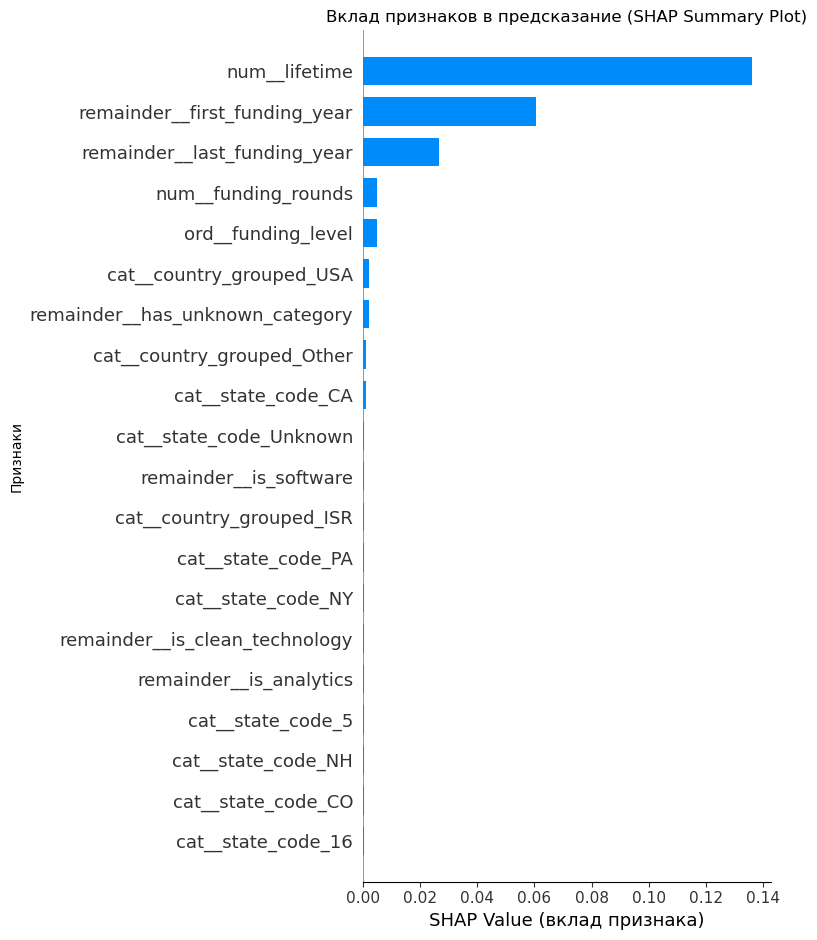

In [61]:
# 1. Трансформируем данные через препроцессор
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_transformed = preprocessor.transform(X_train)

# 2. Получаем имена признаков
feature_names = preprocessor.get_feature_names_out()

# 3. Определим функцию предсказания
model = randomized_search.best_estimator_.named_steps['models']
predict_fn = lambda x: model.predict_proba(x)

# 4. Задаём фоновые данные
background = shap.utils.sample(X_transformed, 100, random_state=42)

# 5. Явно вызываем KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background)

# 6. Вычисляем SHAP значения (с ограничением)
shap_values = explainer.shap_values(X_transformed[:100])  # можно увеличить позже 
shap_values_class_1 = shap_values[:,:, 1]

# 7. Визуализация
shap.summary_plot(
    shap_values_class_1,
    features=X_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title("Вклад признаков в предсказание (SHAP Summary Plot)")
plt.xlabel("SHAP Value (вклад признака)")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

## Предсказание и экспорт

- Прогноз на `test`
- Сохранение результатов

In [63]:
# Предсказание (0 или 1) на тестовой выборке
y_test_pred = randomized_search.predict(test)

# Преобразуем обратно в исходные метки
# Предположим, что исходное сопоставление у нас такое:
# 0 — 'operating', 1 — 'closed'
status_mapping = {0: 'operating', 1: 'closed'}
y_test_labels = pd.Series(y_test_pred).map(status_mapping)

# Собираем DataFrame с названиями компаний
submission = pd.DataFrame({
    'name': test_names,
    'status': y_test_labels
})

# Сохраняем в файл
submission.to_csv('predicted_startups_status.csv', index=False)

print("Файл 'predicted_startups_status.csv' успешно сохранён.")

Файл 'predicted_startups_status.csv' успешно сохранён.


# Вывод

## Цель проекта

Предсказать, закроется ли стартап (статус `closed`) или продолжит работать (статус `operating`) на основе различных характеристик: инвестиций, индустрии, времени, географии и др.

## Что было сделано

1. **Анализ и подготовка данных**:
    - Проведен EDA, визуализация, фильтрация по странам и категориям;
    - Выявлены слабые корреляции между признаками;
    - Преобразованы признаки времени (например, выделены года финансирования);
    - Добавлены новые признаки (`funding_level`, `country_grouped`, `lifetime` и др.);
    - Закодированы категориальные признаки (`OneHot`, `Ordinal`);
    - Построены пайплайны с учетом обработки пропусков, масштабирования и кодирования.
2. **Моделирование**:
    - Рассмотрены модели: `DecisionTree`, `KNeighbors`, `LogisticRegression`, `RandomForest`;
    - Использовался `RandomizedSearchCV` для подбора параметров;
    - Протестирован `SMOTE`, но он не улучшил результаты;
    - Итоговая модель — `KNeighborsClassifier(n_neighbors=5)`.
3. **Оценка и результаты**:
    - Лучшая модель показала:
        - `f1-score` по классу `closed`: **0.81**
        - `accuracy`: **0.97**
        - `macro f1`: **0.87**
    - SHAP-анализ подтвердил важность признаков: `funding_level`, `lifetime`, `funding_rounds`, `country_grouped`.
4. **Финальный экспорт**:
    - Предсказания сделаны на тестовой выборке и экспортированы в формате: `name`, `status`.

## Чего добились

- Удалось добиться **хорошего баланса** между точностью и полнотой по классу `closed`, несмотря на дисбаланс классов.
- Модель стабильно показывает **высокое качество на валидационной выборке**.

## Что можно улучшить

- Улучшить обработку пропущенных значений, особенно в ключевых числовых признаках;
- Протестировать дополнительные модели (например, `LightGBM`, `CatBoost`);
- Добавить больше фичей, основанных на временных характеристиках (например, время между инвестициями, "старость" стартапа);
- Рассмотреть вложенные пайплайны с учетом специфики индустрий;
- Сделать модель более интерпретируемой для бизнеса через feature selection и упрощение;
- Добавить внешние источники данных (например, макроэкономика, данные о инвесторах).